# COVID-19 Interactive Dashboard (OWID Dataset)

This notebook prepares COVID-19 case data for **interactive visualization** using the **Our World in Data (OWID)** dataset.  
The goal is to build a clean **time-series dataset** and generate plots that will later be integrated into a **Streamlit dashboard**.

---

## 🔹 Pipeline Overview
1. **Load Data**
   - Use the Kaggle dataset you added: *COVID-19 (coronavirus) dataset by OWID*
   - Fallback: `data/owid-covid-data.csv` if present

2. **Preprocessing**
   - Select relevant columns, parse dates
   - Handle missing values and infinities
   - Compute per-million metrics and rolling averages

3. **Exploratory Plots**
   - Daily cases/deaths time series (7-day averages)
   - Country comparisons

4. **Dashboard Integration**
   - Export cleaned dataset to `data/owid_clean.csv`
   - (Optional) Save static plots to `plots/`
   - Use the cleaned dataset in **Streamlit** app (`app.py`)

In [17]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio

# Ensure folders
os.makedirs("data", exist_ok=True)
os.makedirs("plots", exist_ok=True)

# Fix Plotly renderer for Kaggle (interactive charts)
pio.renderers.default = "plotly_mimetype"

# Detect Kaggle OWID dataset path
def find_owid_csv():
    candidates = glob.glob("/kaggle/input/**/owid-covid-data.csv", recursive=True)
    return candidates[0] if candidates else None

CSV_KAGGLE = find_owid_csv()
CSV_LOCAL = "data/owid-covid-data.csv"
print("Detected Kaggle CSV:", CSV_KAGGLE)


Detected Kaggle CSV: /kaggle/input/covid19-coronavirus-dataset-by-owid/owid-covid-data.csv


In [18]:
# Load OWID dataset, then clean
parse_cols = ["date"]

if CSV_KAGGLE and os.path.exists(CSV_KAGGLE):
    df = pd.read_csv(CSV_KAGGLE, parse_dates=parse_cols)
    print("Loaded from Kaggle:", CSV_KAGGLE)
elif os.path.exists(CSV_LOCAL):
    df = pd.read_csv(CSV_LOCAL, parse_dates=parse_cols)
    print("Loaded local file:", CSV_LOCAL)
else:
    raise FileNotFoundError(
        "OWID CSV not found. On Kaggle, use 'Add Data' to attach the OWID dataset."
    )

print("Raw shape:", df.shape)

# ---- clean & silence warnings (MUST be AFTER df is defined) ----
df.replace([np.inf, -np.inf], np.nan, inplace=True)  # replace infinities
np.seterr(invalid="ignore")                          # silence NaN-comparison warnings

df.head()


Loaded from Kaggle: /kaggle/input/covid19-coronavirus-dataset-by-owid/owid-covid-data.csv
Raw shape: (350108, 67)


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN


In [19]:
# Keep relevant columns
cols = [
    "iso_code","continent","location","date","population",
    "new_cases","new_deaths","total_cases","total_deaths",
    "new_vaccinations","people_vaccinated","people_fully_vaccinated","total_boosters"
]
df_small = df[cols].copy()

# Replace ±inf with NaN to avoid formatting/runtime warnings
df_small.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop aggregates (world/continent totals)
drop_iso = {"OWID_WRL","OWID_AFR","OWID_ASI","OWID_EUR","OWID_EUN",
            "OWID_INT","OWID_NAM","OWID_OCE","OWID_SAM"}
df_small = df_small[~df_small["iso_code"].isin(drop_iso)]

# Fill missing values for daily flows (OK to assume 0 before reporting starts)
for c in ["new_cases","new_deaths","new_vaccinations"]:
    if c in df_small.columns:
        df_small[c] = df_small[c].fillna(0)

# Per-million metrics
for src, new in [("new_cases","new_cases_per_million"),
                 ("new_deaths","new_deaths_per_million"),
                 ("new_vaccinations","new_vaccinations_per_million")]:
    if src in df_small.columns:
        df_small[new] = np.where(
            (df_small["population"]>0) & df_small[src].notna(),
            df_small[src] / (df_small["population"]/1_000_000.0),
            np.nan
        )

# Rolling averages (7-day)
df_small = df_small.sort_values(["location","date"])
for m in ["new_cases","new_deaths","new_vaccinations",
          "new_cases_per_million","new_deaths_per_million","new_vaccinations_per_million"]:
    if m in df_small.columns:
        df_small[f"{m}_ra7"] = df_small.groupby("location")[m].transform(
            lambda s: s.rolling(7, min_periods=1).mean()
        )

print("Preprocessed shape:", df_small.shape)
df_small.head(3)

Preprocessed shape: (338993, 22)


,iso_code,continent,location,date,population,new_cases,new_deaths,total_cases,total_deaths,new_vaccinations,...,total_boosters,new_cases_per_million,new_deaths_per_million,new_vaccinations_per_million,new_cases_ra7,new_deaths_ra7,new_vaccinations_ra7,new_cases_per_million_ra7,new_deaths_per_million_ra7,new_vaccinations_per_million_ra7
0,AFG,Asia,Afghanistan,2020-01-03,41128772.0,0.0,0.0,NaN,NaN,0.0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AFG,Asia,Afghanistan,2020-01-04,41128772.0,0.0,0.0,NaN,NaN,0.0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,AFG,Asia,Afghanistan,2020-01-05,41128772.0,0.0,0.0,NaN,NaN,0.0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# Helper: filter rows after outbreak started (first day with cumulative > 0)
def filter_after_outbreak(frame, by="location", cum_col="total_cases"):
    mask = (
        frame[cum_col].fillna(0).gt(0)
        .groupby(frame[by]).transform(lambda s: s.cummax())
    )
    return frame[mask].copy().sort_values([by, "date"])

# Example default countries
default_countries = ["United States","Taiwan","Italy","Japan"]

# Create preview frame filtered by countries and after outbreak
preview = df_small[df_small["location"].isin(default_countries)].copy()
preview = filter_after_outbreak(preview, by="location", cum_col="total_cases")

print("Preview shape after filtering:", preview.shape)
print("Date range:", preview["date"].min(), "→", preview["date"].max())
preview.head(8)

Preview shape after filtering: (4104, 22)
Date range: 2020-01-14 00:00:00 → 2023-10-23 00:00:00


,iso_code,continent,location,date,population,new_cases,new_deaths,total_cases,total_deaths,new_vaccinations,...,total_boosters,new_cases_per_million,new_deaths_per_million,new_vaccinations_per_million,new_cases_ra7,new_deaths_ra7,new_vaccinations_ra7,new_cases_per_million_ra7,new_deaths_per_million_ra7,new_vaccinations_per_million_ra7
149516,ITA,Europe,Italy,2020-01-31,59037472.0,3.0,0.0,3.0,NaN,0.0,...,NaN,0.050815,0.0,0.0,0.428571,0.0,0.0,0.007259,0.0,0.0
149517,ITA,Europe,Italy,2020-02-01,59037472.0,0.0,0.0,3.0,NaN,0.0,...,NaN,0.000000,0.0,0.0,0.428571,0.0,0.0,0.007259,0.0,0.0
149518,ITA,Europe,Italy,2020-02-02,59037472.0,0.0,0.0,3.0,NaN,0.0,...,NaN,0.000000,0.0,0.0,0.428571,0.0,0.0,0.007259,0.0,0.0
149519,ITA,Europe,Italy,2020-02-03,59037472.0,0.0,0.0,3.0,NaN,0.0,...,NaN,0.000000,0.0,0.0,0.428571,0.0,0.0,0.007259,0.0,0.0
149520,ITA,Europe,Italy,2020-02-04,59037472.0,0.0,0.0,3.0,NaN,0.0,...,NaN,0.000000,0.0,0.0,0.428571,0.0,0.0,0.007259,0.0,0.0
149521,ITA,Europe,Italy,2020-02-05,59037472.0,0.0,0.0,3.0,NaN,0.0,...,NaN,0.000000,0.0,0.0,0.428571,0.0,0.0,0.007259,0.0,0.0
149522,ITA,Europe,Italy,2020-02-06,59037472.0,0.0,0.0,3.0,NaN,0.0,...,NaN,0.000000,0.0,0.0,0.428571,0.0,0.0,0.007259,0.0,0.0
149523,ITA,Europe,Italy,2020-02-07,59037472.0,0.0,0.0,3.0,NaN,0.0,...,NaN,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0


In [21]:
# Bulletproof plotting: normal show + HTML embed fallback + static PNG
from IPython.display import HTML, display

def force_show(fig, html_name):
    # try normal show
    try:
        fig.show()
        shown = True
    except Exception:
        shown = False

    # HTML fallback (guaranteed)
    try:
        html = fig.to_html(include_plotlyjs="cdn", full_html=False)
        display(HTML(html))
        fig.write_html(f"plots/{html_name}.html", include_plotlyjs="cdn")
    except Exception:
        pass

    # Static PNG fallback
    try:
        fig.write_image(f"plots/{html_name}.png", scale=2)
    except Exception:
        # if kaleido not installed, produce a quick Matplotlib fallback
        import matplotlib.pyplot as plt
        plt.figure(figsize=(7,4))
        # Simple static line plot using pandas (per location)
        # (Only for emergency; not as pretty as Plotly)
        # Here we skip as Plotly usually works with HTML fallback.
        plt.close()

def make_line(data, y_col, title, y_label, html_name):
    plot_df = data.dropna(subset=[y_col]).copy()
    print(f"{y_col} non-NaN rows:", len(plot_df))
    if plot_df.empty:
        print(f"⚠️ No non-NaN data for {y_col}.")
        return
    fig = px.line(
        plot_df, x="date", y=y_col, color="location",
        title=title, labels={y_col: y_label, "date":"Date"}
    )
    force_show(fig, html_name)

make_line(preview, "new_cases_per_million_ra7",
          "New Cases per Million (7-day average)",
          "Cases / 1M (RA7)", "new_cases_per_million_ra7")

make_line(preview, "new_deaths_per_million_ra7",
          "New Deaths per Million (7-day average)",
          "Deaths / 1M (RA7)", "new_deaths_per_million_ra7")

new_cases_per_million_ra7 non-NaN rows: 4104


new_deaths_per_million_ra7 non-NaN rows: 4104


In [22]:
clean_path = "data/owid_clean.csv"
df_small.to_csv(clean_path, index=False)
print("Saved cleaned dataset →", clean_path)

Saved cleaned dataset → data/owid_clean.csv


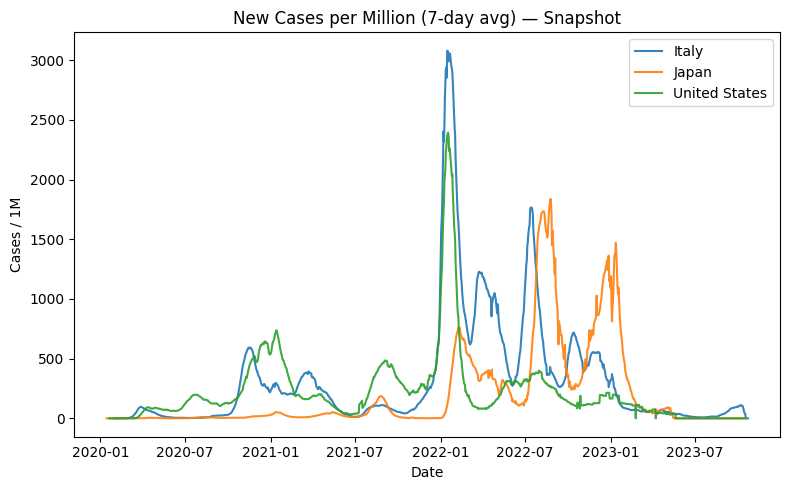

Saved → plots/new_cases_ra7_snapshot.png


In [23]:
# Optional static PNG snapshot for README/screenshots
sample = preview.pivot_table(index="date", columns="location", values="new_cases_per_million_ra7")
plt.figure(figsize=(8,5))
for col in sample.columns:
    plt.plot(sample.index, sample[col], label=col, alpha=0.9)
plt.legend()
plt.title("New Cases per Million (7-day avg) — Snapshot")
plt.xlabel("Date"); plt.ylabel("Cases / 1M")
plt.tight_layout()
plt.savefig("plots/new_cases_ra7_snapshot.png", dpi=150)
plt.show()
print("Saved → plots/new_cases_ra7_snapshot.png")

In [24]:
import shutil
shutil.copy("data/owid_clean.csv", "/kaggle/working/owid_clean.csv")

'/kaggle/working/owid_clean.csv'

In [25]:
df_small.to_csv("/kaggle/working/owid_clean.csv", index=False)